In [1]:
%load_ext autoreload
%autoreload 2

import os
import sys
HLA_associations_path = os.path.abspath("../")
sys.path.append(HLA_associations_path)

import numpy as np
import pandas as pd
import scipy.stats as stats

import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.notebook import tqdm

import constants, index_tools, data_tools, medical_code_tools
from utilities import *
from analysis import *


In [2]:
sns.set_palette("tab10")
plt.rcParams.update({'figure.max_open_warning': 0})

In [3]:
loaded = False

# Load BioBank Components

In [4]:
DEV_MODE = False
SIGNIFIER = ""

if not loaded:
    (biobank_data_no_HLA_alleles, biobank_index,
     med_code_mapping) = data_tools.load_all_biobank_components(DEV_MODE, signifier=SIGNIFIER)
    loaded = True
    HLA_alleles = data_tools.load_HLA_data()
    biobank_data = biobank_data_no_HLA_alleles.merge(HLA_alleles, how="left", on="eid")

Importing BioBank Index and Data:
Missing 0 biobank index names
Reduced feature set has 376 features.
UK BioBank Data Loaded.
Size: 502536 rows x 376 columns
Elapsed time: 102.6930 seconds


Mapping Medical Codes:   0%|          | 0/361 [00:00<?, ? feature/s]

# Conditions / Condition Search

In [5]:
autoimmune_conditions = ["type 1 diabetes", "rheumatoid arthritis",
                         "psoriasis", "asthma", "multiple sclerosis", "systemic lupus erythematosis/sle",
                         "inflammatory bowel disease", "grave's disease", "hypothyroidism/myxoedema",
                         "hyperthyroidism/thyrotoxicosis", "myasthenia gravis", "pernicious anaemia",
                         "sjogren's syndrome/sicca syndrome", "eczema/dermatitis",
                         'acute infective polyneuritis/guillain-barre syndrome', "malabsorption/coeliac disease",
                        ]

psychiatric_conditions = ["schizophrenia", "depression", "mania/bipolar disorder/manic depression",
                          "obsessive compulsive disorder (ocd)", "anxiety/panic attacks",
                          "alcohol dependency"]

other_conditions = ["vasculitis", "hypertension"]
neurological_conditions = ["epilepsy"]

HLA_dosing_conditions = {"psychiatric": psychiatric_conditions, "autoimmune": autoimmune_conditions, 
                         "other": other_conditions}

data_tools.biobank_search(med_code_mapping, biobank_data, ('alz')).query("count > 0")

,coding,meaning,code_format,name,count
136,1263,dementia/alzheimers/cognitive impairment,6,illness_code,39


In [7]:
illness_codes = [feature for feature in biobank_data.columns if get_base_feature(feature) == "illness_code"]
all_illnesses = biobank_data[illness_codes].values.ravel()
all_illnesses, counts = np.unique(all_illnesses[~pd.isnull(all_illnesses)], return_counts=True)
all_illnesses = all_illnesses[counts > 30]

In [8]:
def get_base_feature(feature: str) -> str:
    """ """
    return "_".join(feature.split("_")[:-1]) if "." in feature else feature

In [9]:
def get_illness_value(data: pd.DataFrame, illness: str, base_feature: str) -> np.ndarray:
    """ Finds all the individuals with a specific illness"""
    assert base_feature in data, f"Invalid base_feature: {base_feature}"
    
    features = [feature for feature in data.columns if get_base_feature(feature) == base_feature]
    
    illness_value = np.zeros(len(data))
    for feature in features:
        illness_value = (data[feature] == illness) | illness_value

    return illness_value

In [10]:
values = []
exposure_feature = "zygosity"
exposure_baseline = None

exposure = biobank_data[exposure_feature].values
exposure_values, counts = np.unique(exposure[~np.isnan(exposure)], return_counts=True)

if exposure_baseline is None or exposure_baseline not in exposure_values:
    exposure_baseline = exposure_values[np.argmax(counts)]

non_baseline_exposure_values = [value for value in exposure_values if value != exposure_baseline]

values = []
for illness in psychiatric_conditions:
    illness_value = get_illness_value(biobank_data, illness, "illness_code")
    illness_label = f"{illness} ({exposure_feature} != {exposure_baseline})"
    values.append([illness_label, *calculate_OR(illness_value, exposure != exposure_baseline)[:3]])
    for value in non_baseline_exposure_values:
        illness_label = f"{illness} ({exposure_feature} == {value})"
        values.append([illness_label, *calculate_OR(illness_value, exposure == value)[:3]])
        
columns = ["illness", "OR", "p-value", "N"]
df = pd.DataFrame(values, columns=columns)
df["significant"] = df["p-value"] < .07
df

,illness,OR,p-value,N,significant
0,schizophrenia (zygosity != 0.0),1.033909,0.709948,158,False
1,schizophrenia (zygosity == 1.0),0.882405,0.311909,84,False
2,schizophrenia (zygosity == 2.0),0.726025,0.169844,20,False
3,schizophrenia (zygosity == 3.0),1.335160,0.200737,21,False
4,depression (zygosity != 0.0),0.978771,0.133224,6928,False
5,depression (zygosity == 1.0),0.997014,0.870924,4257,False
6,depression (zygosity == 2.0),0.991268,0.788024,1232,False
7,depression (zygosity == 3.0),1.079494,0.043897,777,True
8,mania/bipolar disorder/manic depression (zygos...,0.966600,0.600523,343,False
9,mania/bipolar disorder/manic depression (zygos...,0.975452,0.766060,209,False


In [11]:
data = biobank_data.query("sex == 'Female'")

for illness in autoimmune_conditions:
    print(illness.upper())
    illness_values = get_illness_value(data, illness, "illness_code")
    print("\t" + variable_OR_test(illness=illness_values, variable="zygosity", data=data).replace('\n', '\n\t'))

TYPE 1 DIABETES
	zygosity != 0.0: OR = 1.354   p-value = 0.04997   95% CI: 1.06 - 1.74   N = 61 ***************
	zygosity = 1.0:  OR = 1.096   p-value = 0.63693   95% CI: 0.81 - 1.48   N = 36
	zygosity = 2.0:  OR = 0.923   p-value = 1.00000   95% CI: 0.53 - 1.62   N = 9
	zygosity = 3.0:  OR = 2.994   p-value = 0.00020   95% CI: 1.95 - 4.59   N = 16 ***************
	
RHEUMATOID ARTHRITIS
	zygosity != 0.0: OR = 1.015   p-value = 0.69703   95% CI: 0.95 - 1.08   N = 876
	zygosity = 1.0:  OR = 1.063   p-value = 0.16974   95% CI: 0.99 - 1.14   N = 624
	zygosity = 2.0:  OR = 0.873   p-value = 0.10776   95% CI: 0.76 - 1.00   N = 152
	zygosity = 3.0:  OR = 0.998   p-value = 1.00000   95% CI: 0.84 - 1.18   N = 100
	
PSORIASIS
	zygosity != 0.0: OR = 0.969   p-value = 0.52161   95% CI: 0.90 - 1.05   N = 566
	zygosity = 1.0:  OR = 1.064   p-value = 0.24910   95% CI: 0.97 - 1.16   N = 418
	zygosity = 2.0:  OR = 0.795   p-value = 0.03124   95% CI: 0.67 - 0.95   N = 93 ***************
	zygosity = 3.0:

# Grantham Distance

Making OR Plots:   0%|          | 0/16 [00:00<?, ? plot/s]

Elapsed time: 0.2009 seconds
Elapsed time: 0.0506 seconds
Elapsed time: 0.5259 seconds
next

Elapsed time: 0.1709 seconds
Elapsed time: 0.0525 seconds
Elapsed time: 0.5840 seconds
next

Elapsed time: 0.1723 seconds
Elapsed time: 0.0400 seconds
Elapsed time: 0.6399 seconds
next

Elapsed time: 0.1703 seconds
Elapsed time: 0.0345 seconds
Elapsed time: 0.6179 seconds
next

Elapsed time: 0.1698 seconds
Elapsed time: 0.0459 seconds
Elapsed time: 0.5711 seconds


KeyboardInterrupt: 

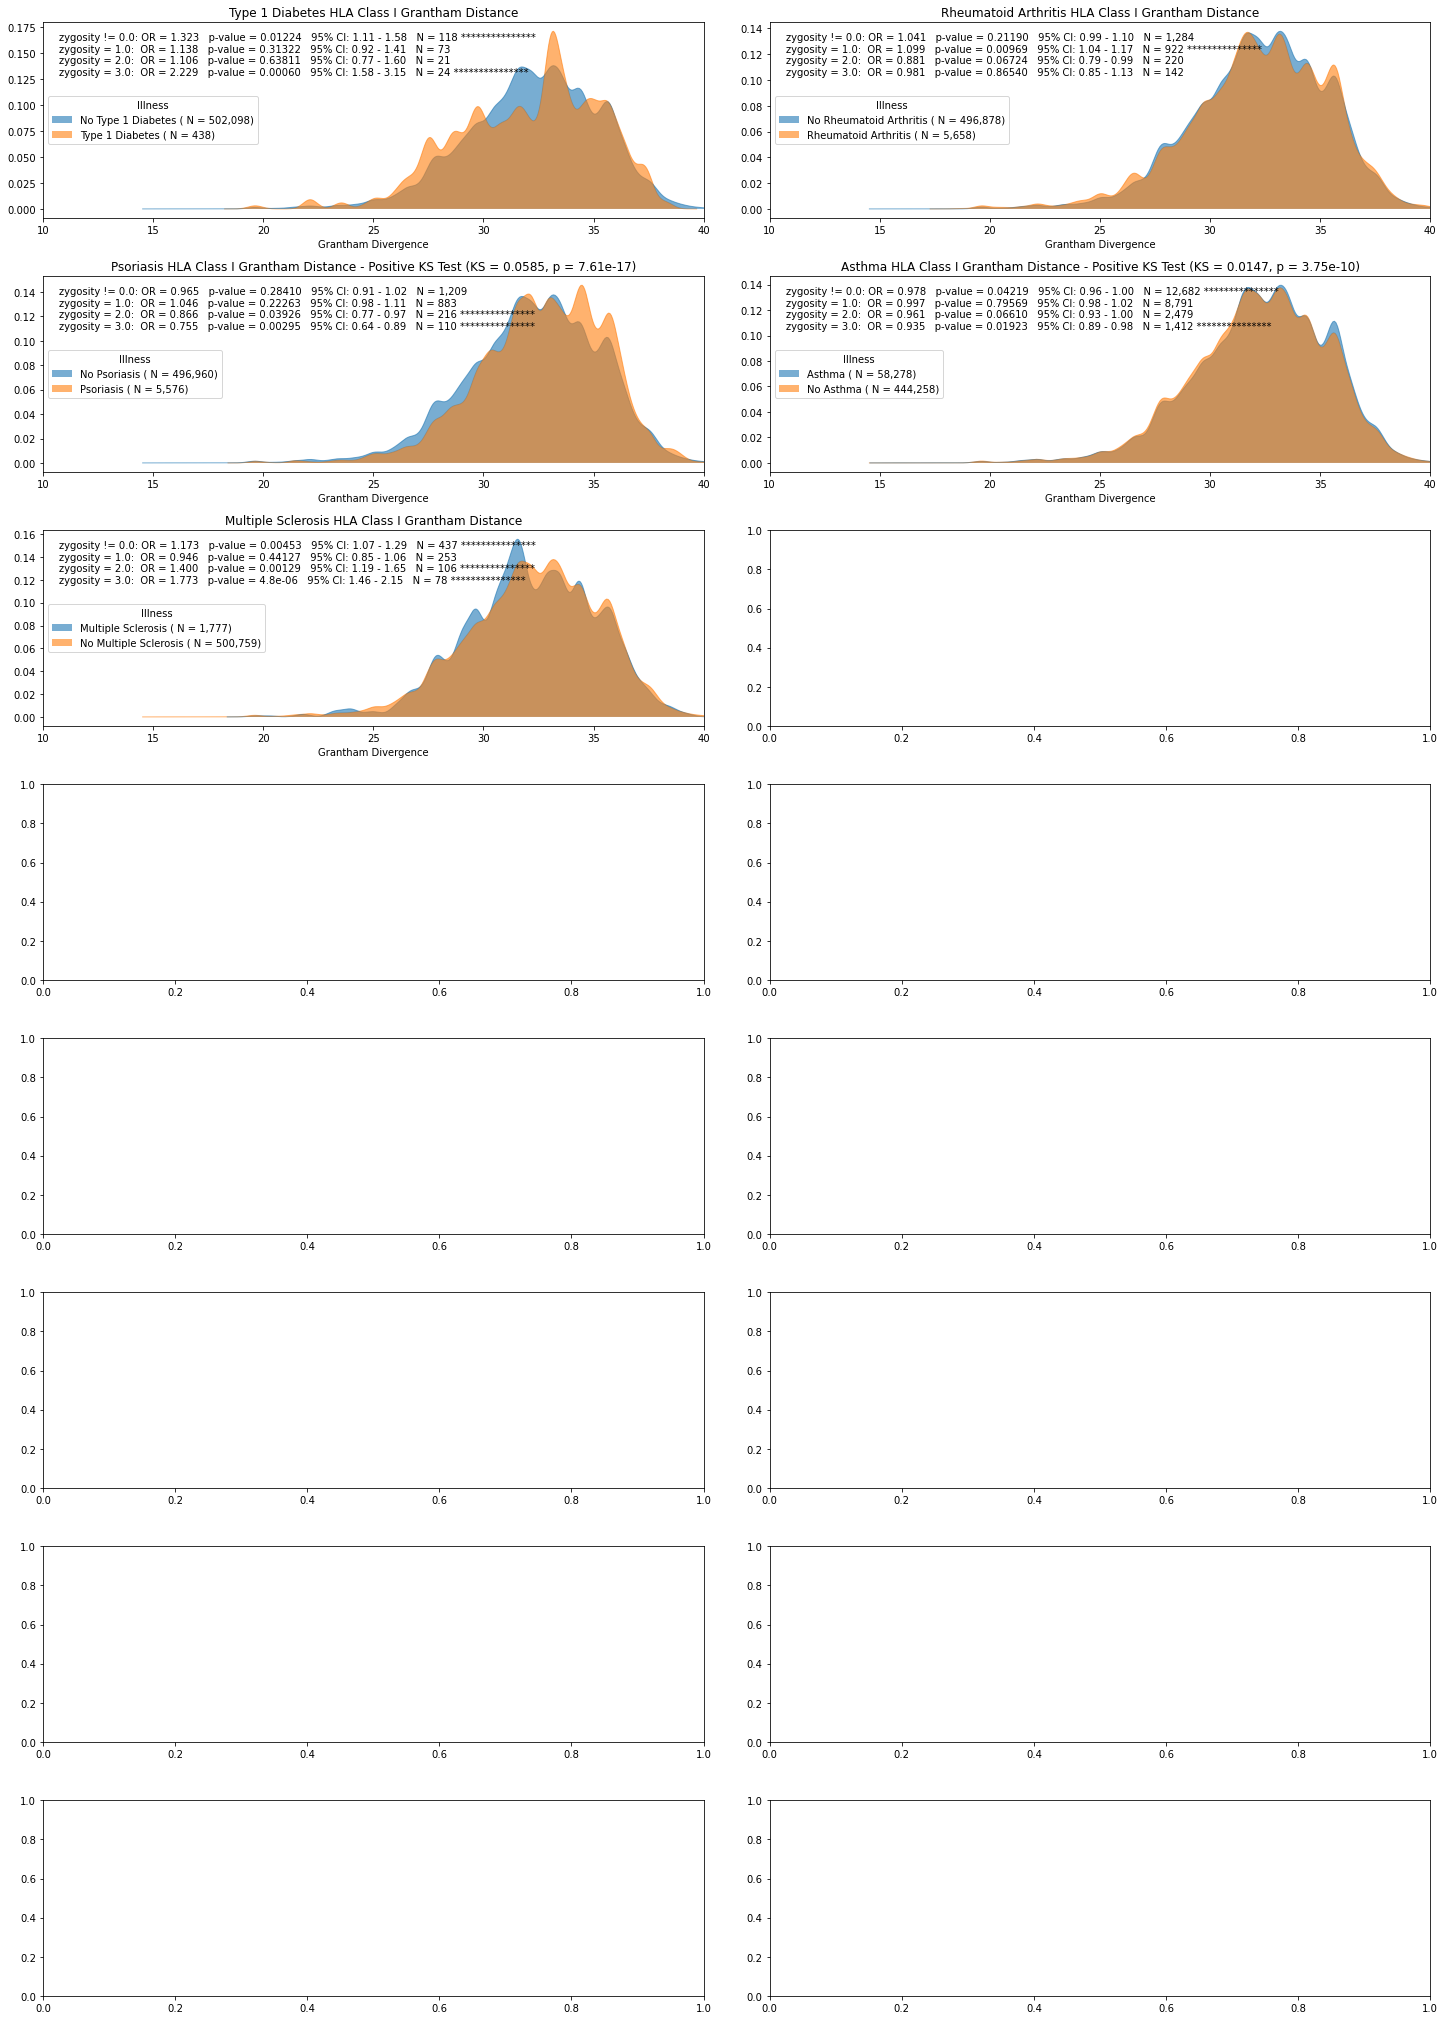

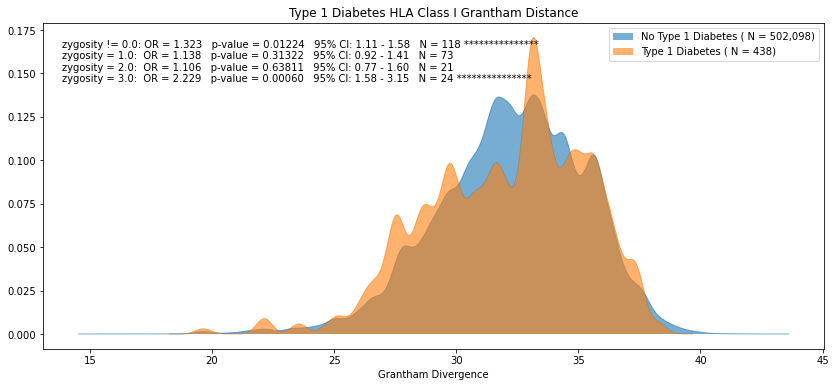

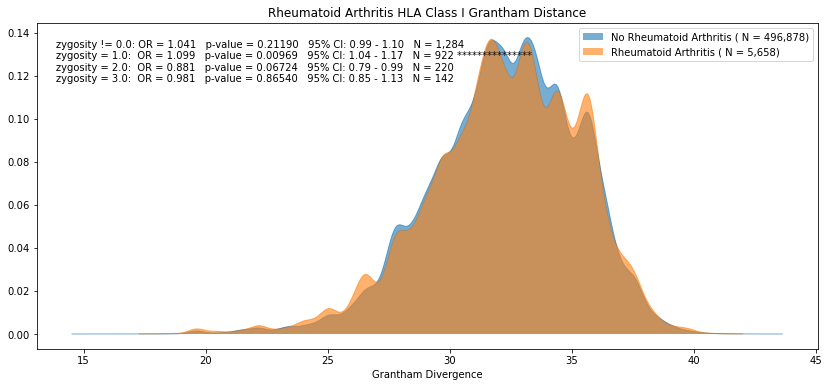

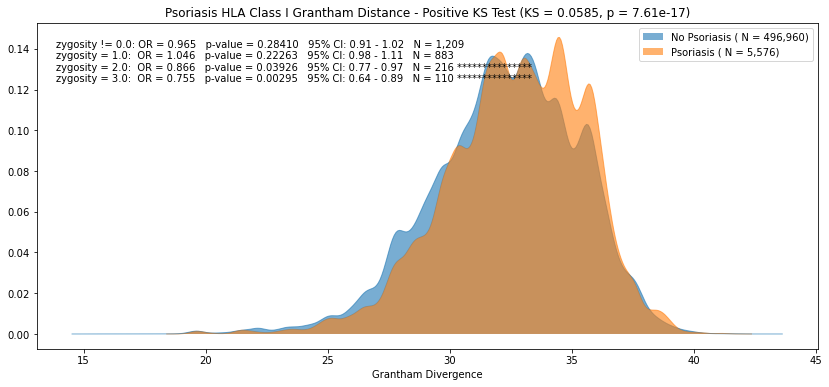

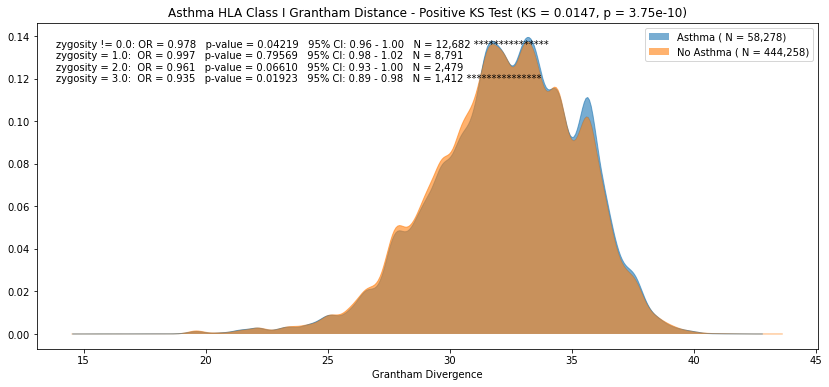

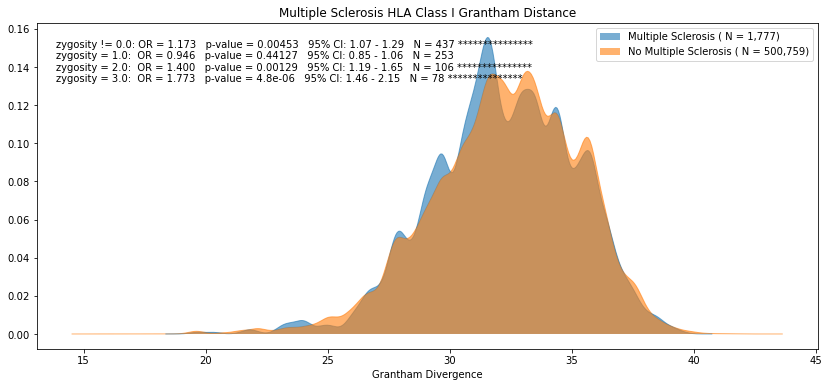

In [21]:
condition = "autoimmune"

conditions = HLA_dosing_conditions[condition]

big_fig, big_axes = create_subplot(len(conditions), width=20, height_per=3, wspace=.1)

for illness, big_ax in tqdm(zip(conditions, big_axes), unit=" plot", desc="Making OR Plots",
                            total=len(big_axes)):

    fig, ax = plt.subplots(figsize=(14, 6))
    x = "grantham_divergence"
        illness_values = get_illness_value(biobank_data, illness, "illness_code")
    
        biobank_data["illness"] = np.array(["no " + illness, illness])[1 * illness_values]
    
#     sns_wrapper(sns.kdeplot, data=biobank_data, x=x, hue="illness", ax=ax, bw_method=.1, common_norm=False, shade=True)
#     sns_wrapper(sns.kdeplot, data=biobank_data, x=x, hue="illness", ax=big_ax, bw_method=.1, common_norm=False, shade=True)

    temp_data = pd.DataFrame({x: biobank_data[x], "illness": biobank_data["illness"]})
    kde_plot(data=temp_data, x=x, hue="illness", ax=ax, bw=.1)
    kde_plot(data=temp_data, x=x, hue="illness", ax=big_ax, bw=.1)
    
    
    text = variable_OR_test(illness=illness_values, variable="zygosity", data=biobank_data)

    
    disease_distances = biobank_data["grantham_divergence"].loc[illness_values]
    no_disease_distances = biobank_data["grantham_divergence"].loc[~illness_values]
    ks_stat, ks_p_value = stats.kstest(disease_distances, no_disease_distances)

    
    if ks_p_value < .05:
        title = f"{illness.title()} HLA Class I Grantham Distance - Positive KS Test (KS = {ks_stat:.03}, p = {ks_p_value:.03})"
    else:
        title = f"{illness.title()} HLA Class I Grantham Distance"
    
    for ax_i in [ax, big_ax]:
        add_plt_labels(ax_i, x=x)
        ax_i.set_title(title)
        ax_i.text(0.025, 0.95, text, transform=ax_i.transAxes, ha="left", va="top")

    big_ax.legend(title="Illness", loc="center left")
    big_ax.set_xlim(10, 40)
    
    illness_label = illness.replace(' ', '_').replace('/', '_').replace("'", "")
    fig.savefig(f"cancer_ICD10_plots/grantham_distance_plots/{condition}/HLA_grantham_distance_{illness_label}.png")
    print("next\n")
big_fig.savefig(f"cancer_ICD10_plots/grantham_distance_plots/{condition}/multiple_HLA_grantham_distance.png")

# All Illnesses Exploration

In [15]:
report = ""
for illness in tqdm(all_illnesses):
    report += illness.upper() + '\n\t'
    illness_values = get_illness_value(biobank_data, illness, "illness_code")
    report += variable_OR_test(illness=illness_values, variable="zygosity", data=biobank_data).replace('\n', '\n\t')
    report += '\n'

print(report)

  0%|          | 0/413 [00:00<?, ?it/s]

/Users/cole/Documents/_research/rabadan_lab/HLA_genotyping_associations/analysis.py:44: RuntimeWarning: divide by zero encountered in true_divide
  standard_error = np.sqrt(np.sum(1 / np.array(contingency_table).ravel()))
/Users/cole/Documents/_research/rabadan_lab/HLA_genotyping_associations/analysis.py:49: RuntimeWarning: divide by zero encountered in log
  upper_bound = np.exp(np.log(odds_ratio) + z_score * standard_error)
/Users/cole/Documents/_research/rabadan_lab/HLA_genotyping_associations/analysis.py:49: RuntimeWarning: invalid value encountered in double_scalars
  upper_bound = np.exp(np.log(odds_ratio) + z_score * standard_error)
/Users/cole/Documents/_research/rabadan_lab/HLA_genotyping_associations/analysis.py:50: RuntimeWarning: divide by zero encountered in log
  lower_bound = np.exp(np.log(odds_ratio) - z_score * standard_error)


KeyboardInterrupt: 

In [225]:
values = []
exposure_feature = "zygosity"
exposure_baseline = None

exposure = biobank_data[exposure_feature].values
exposure_values, counts = np.unique(exposure[~np.isnan(exposure)], return_counts=True)

if exposure_baseline is None or exposure_baseline not in exposure_values:
    exposure_baseline = exposure_values[np.argmax(counts)]

non_baseline_exposure_values = [value for value in exposure_values if value != exposure_baseline]

values = []
for illness in tqdm(all_illnesses):
    illness_value = get_illness_value(biobank_data, illness, "illness_code")
    illness_label = f"{illness} ({exposure_feature} != {exposure_baseline})"
    values.append([illness_label, *calculate_OR(illness_value, exposure != exposure_baseline)[:3]])
    for value in non_baseline_exposure_values:
        illness_label = f"{illness} ({exposure_feature} == {value})"
        values.append([illness_label, *calculate_OR(illness_value, exposure == value)[:3]])
        
columns = ["illness", "OR", "p-value", "N"]
df = pd.DataFrame(values, columns=columns)
df["significant"] = df["p-value"] < .07
df.head()

  0%|          | 0/413 [00:00<?, ?it/s]

,illness,OR,p-value,N,significant
0,abdominal hernia (zygosity != 0.0),1.049158,0.700607,84,False
1,abdominal hernia (zygosity == 1.0),1.168089,0.278967,56,False
2,abdominal hernia (zygosity == 2.0),0.618325,0.175474,9,False
3,abdominal hernia (zygosity == 3.0),0.957480,1.000000,8,False
4,abnormal smear (cervix) (zygosity != 0.0),0.956122,0.631094,169,False
...,...,...,...,...,...
1647,whooping cough / pertussis (zygosity == 3.0),1.229148,0.398665,16,False
1648,wolff parkinson white / wpw syndrome (zygosity...,1.020339,0.897202,20,False
1649,wolff parkinson white / wpw syndrome (zygosity...,1.105097,0.752915,13,False
1650,wolff parkinson white / wpw syndrome (zygosity...,0.857173,1.000000,3,False


In [241]:
df["OR"].apply(lambda s: 1 - 1/s if s != 0 else 0 if s < 1 else s - 1)

0       0.046855
1       0.143901
2      -0.617271
3      -0.044408
4      -0.045892
          ...   
1647    0.186429
1648    0.019934
1649    0.095102
1650   -0.166625
1651    0.000000
Name: OR, Length: 1652, dtype: float64

<AxesSubplot:xlabel='p-value', ylabel='N'>

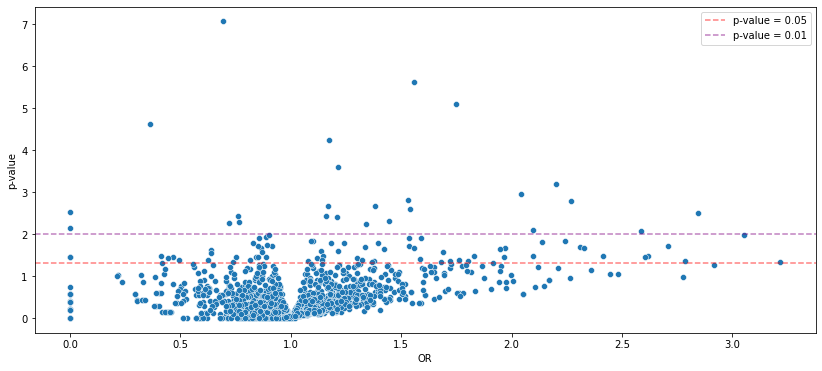

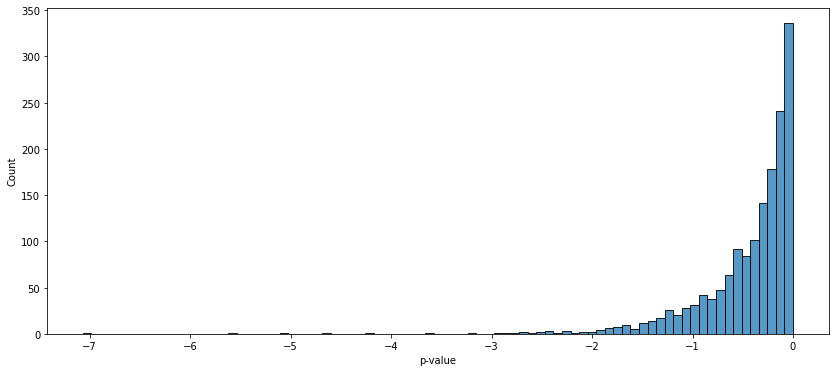

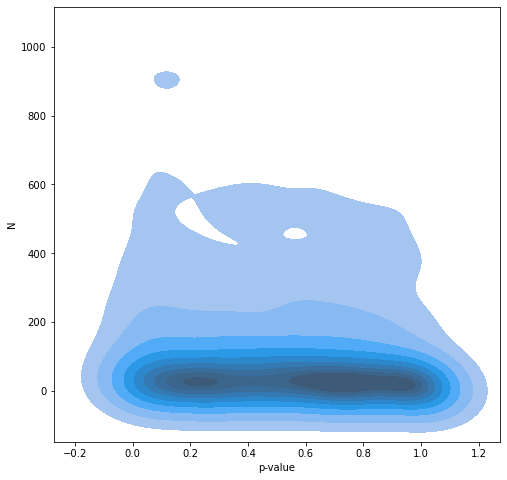

In [288]:
data = df.loc[(-np.log10(df['p-value']) < 30) & (df["N"] < 1_000)]

fig, ax = plt.subplots(figsize=(14, 6))
sns.scatterplot(data=data, x="OR", y=-np.log10(df["p-value"]))
ax.axhline(-np.log10(.05), linestyle="--", color="r", label="p-value = 0.05", alpha=.5)
ax.axhline(-np.log10(.01), linestyle="--", color="purple", label="p-value = 0.01", alpha=.5)
ax.legend()

fig, ax = plt.subplots(figsize=(14, 6))
sns.histplot(x=np.log10(data["p-value"])) #, shade=True, bw_method=.1)

fig, ax = plt.subplots(figsize=(8, 8))
sns.kdeplot(data=data, x="p-value", y="N", shade=True)
# ax.set_xscale("log")
# ax.set_yscale("log")